In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm

from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta, datetime

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

#  클라이언트 설정



In [15]:
query = """
    with click1 as 
  (select event_dttm, event_dt, user_id
  FROM `ballosodeuk.dw.fact_airbridge_event`, unnest(event_detail)
  where 1=1
    and event_dt between "2024-12-30" and {end_date}
    and event_category in ('c__shopping_home__quick__btn (App)'))

,click2 as 
  (select event_dttm, event_dt, user_id
  FROM `ballosodeuk.dw.fact_airbridge_event`, unnest(event_detail)
  where 1=1
    and event_dt between "2024-12-30" and {end_date}
    and event_category in ('c__all_income_s_money__to_exchange__btn (App)')
    )


,user_param as (
select distinct event_dt, user_id
from
  (select distinct event_dt, user_id from click1
  union all
  select distinct event_dt, user_id from click2
  ))

select a.user_id, event_dt, current_cash
from user_param a
left join ballosodeuk.dw.dim_airbridge_member b on a.user_id = b.user_id
order by user_id, event_dt

"""



In [3]:
yester_day = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
# formatted_query = query.format(
#     end_date=f"'{yester_day}'"
# )

# df = bq.query(formatted_query).to_dataframe()
# df.to_parquet(f"./data/click_param_{yester_day}.parquet")
df = pd.read_parquet(f"./data/click_param_{yester_day}.parquet")

In [4]:
df = df.query("user_id.notnull()")
df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)
df['event_dt'] = pd.to_datetime(df.event_dt.astype(str))

<ipython-input-4-90d58f8dbcc6>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)


In [5]:
df.sort_values(by=['user_id','event_dt'],inplace=True)
df['days_between_visits'] = df.groupby('user_id').event_dt.diff().dt.days


In [6]:
# 더 효율적인 방법으로 일별 커버리지 계산
def calculate_daily_coverage(df):
    # 전체 유니크 유저 수 계산
    total_unique_users = df['user_id'].nunique()
    
    # 날짜별 커버리지 계산 (vectorized operation 사용)
    daily_coverage = (df.groupby('event_dt')['user_id']
                     .nunique()
                     .reset_index()
                     .rename(columns={'user_id': 'daily_users'}))
    
    # 커버리지 비율 계산
    daily_coverage['coverage_rate'] = (daily_coverage['daily_users'] / total_unique_users * 100)
    
    return daily_coverage[['event_dt', 'coverage_rate','daily_users']]

# 결과 출력
daily_coverage = calculate_daily_coverage(df)
print("일자별 전체 유니크 유저 포함률:")
print(daily_coverage.set_index('event_dt').sort_index())
print(f"\n평균 포함률: {daily_coverage['coverage_rate'].mean():.1f}%")

일자별 전체 유니크 유저 포함률:
            coverage_rate  daily_users
event_dt                              
2024-12-30      32.707837        52169
2024-12-31      29.477116        47016
2025-01-01      22.643260        36116
2025-01-02      20.839498        33239
2025-01-03      17.642006        28139
2025-01-04      18.492163        29495
2025-01-05      16.682132        26608
2025-01-06      16.972414        27071
2025-01-07      15.588715        24864
2025-01-08      14.265204        22753
2025-01-09      14.079624        22457
2025-01-10      13.101567        20897
2025-01-11      13.683386        21825
2025-01-12      13.549843        21612
2025-01-13      14.109718        22505
2025-01-14      13.675862        21813
2025-01-15      12.784953        20392
2025-01-16      12.937304        20635
2025-01-17      12.004389        19147
2025-01-18      12.496552        19932
2025-01-19      12.073354        19257
2025-01-20      12.499687        19937
2025-01-21      12.080878        19269
2025-0

In [33]:
pd.to_datetime(df__['last_visit'])

user_id
000087ef-6929-4532-85be-33661b2082d5   2025-01-17
0000d355-7050-4a3e-90d1-2aa0b1198aba   2024-12-31
00022901-aed3-4327-bb0a-29bbdc978dfa   2024-12-30
000256cd-ebbd-46ac-94e9-93a2b1ace57d   2025-02-03
0002ee0b-520c-4e47-84d1-3847ecf3cc9a   2025-01-29
                                          ...    
fffe79ad-6b13-422c-b24d-cb2fc04bdee4   2024-12-31
ffff4ddd-d4b3-4df1-bcb1-545edba93d13   2025-01-12
ffff92f1-7756-49e9-88e9-f2e545ecddb9   2025-02-01
ffff9afc-f69f-4c83-812f-8454f740abfb   2024-12-30
fffff0da-172e-421f-87be-12324d714cbd   2025-02-03
Name: last_visit, Length: 159500, dtype: datetime64[ns]

#### 방문 확률 통계치

In [220]:
df__ = df.groupby('user_id').\
    agg({'days_between_visits':'mean','current_cash':'first','event_dt':['first','last','count']})

new_columns = ['avg_visit', 'current_cash', 'first_visit', 'last_visit', 'visit_count']
df__.columns = new_columns
df__['been_last_visit'] = (datetime.today() - pd.to_datetime(df__['last_visit'])).dt.days
# df__.groupby('been_last_visit').agg({'user_id':'count'}).sort_index()
df__ = df__.reset_index()
df__.groupby('been_last_visit').agg({'user_id':'count'}).sort_index()
df__.head()

,user_id,avg_visit,current_cash,first_visit,last_visit,visit_count,been_last_visit
0,000087ef-6929-4532-85be-33661b2082d5,2.750000,25905,2025-01-06,2025-01-17,5,19
1,0000d355-7050-4a3e-90d1-2aa0b1198aba,1.000000,8636,2024-12-30,2024-12-31,2,36
2,00022901-aed3-4327-bb0a-29bbdc978dfa,NaN,18658,2024-12-30,2024-12-30,1,37
3,000256cd-ebbd-46ac-94e9-93a2b1ace57d,4.142857,7283,2025-01-05,2025-02-03,8,2
4,0002ee0b-520c-4e47-84d1-3847ecf3cc9a,6.333333,11763,2025-01-10,2025-01-29,4,7


#### 시간 감쇠 피쳐

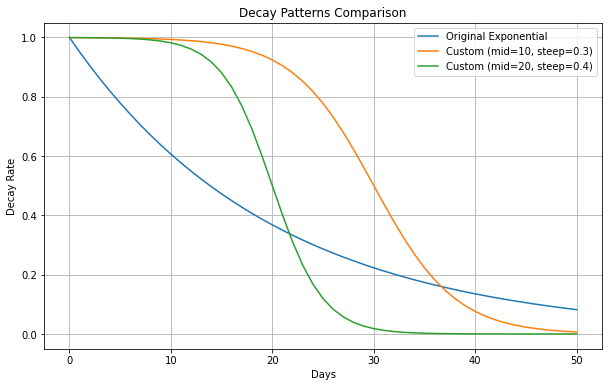

In [221]:
import numpy as np
import matplotlib.pyplot as plt

def custom_decay(days, midpoint=15, steepness=0.3):
    """
    days: 경과 일수
    midpoint: 감쇠가 가속화되는 변곡점 (일)
    steepness: 감쇠 속도 (높을수록 더 가파름)
    """
    return 1 / (1 + np.exp(steepness * (days - midpoint)))

# 비교를 위한 여러 decay 패턴
days = np.arange(0, 51)
original_decay = np.exp(-0.05 * days)
custom_decay1 = custom_decay(days, midpoint=30, steepness=0.25)
custom_decay2 = custom_decay(days, midpoint=20, steepness=0.4)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(days, original_decay, label='Original Exponential')
plt.plot(days, custom_decay1, label='Custom (mid=10, steep=0.3)')
plt.plot(days, custom_decay2, label='Custom (mid=20, steep=0.4)')
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Decay Rate')
plt.title('Decay Patterns Comparison')
plt.legend()
plt.show()

#### 이탈율 계산

In [222]:
# time decay 패턴 생성
days = np.arange(0, 51)  # 0일부터 50일까지
decay_probs = custom_decay(days, midpoint=30, steepness=0.25)

# dictionary로 매핑 테이블 생성
decay_map = dict(zip(days, decay_probs))

# df의 been_last_visit 열에 decay 확률 매핑
df__['time_decay'] = df__['been_last_visit'].map(decay_map)

# 최종 방문 확률 계산
df__['visit_prob'] = df__['time_decay'] * (df__['visit_count'] / df__['been_last_visit'])
df__['visit_prob'] = df__['visit_prob'].clip(0, 1)  # 0~1 사이로 제한

print("방문 확률 분포:")
print(df__['visit_prob'].describe())


방문 확률 분포:
count    159500.000000
mean          0.372221
std           0.409079
min           0.004001
25%           0.023596
50%           0.142404
75%           0.998073
max           1.000000
Name: visit_prob, dtype: float64


#### 현실 DAU 와 맞는 파라미터 도출

In [223]:
def simulate_daily_visits(df, n_days=100, seed=42):
    # np.random.seed(seed)

    # 일별 시뮬레이션
    daily_visits = []
    for day in range(n_days):
        # 베르누이 시행으로 각 유저의 방문/미방문 결정
        visits = np.random.binomial(n=1, p=df['visit_prob'])
        n_visitors = visits.sum()
        daily_visits.append({
            'day': day + 1,
            'n_visitors': n_visitors,
            'visitor_ids': df[visits == 1]['user_id'].tolist()
        })
    
    return pd.DataFrame(daily_visits)

# # 시뮬레이션 실행
simulation_results = simulate_daily_visits(df__)

# # 결과 분석
print("일별 방문자 수 통계:")
print(simulation_results['n_visitors'].describe())

일별 방문자 수 통계:
count      100.000000
mean     59391.060000
std        116.644398
min      59109.000000
25%      59302.000000
50%      59398.500000
75%      59468.500000
max      59716.000000
Name: n_visitors, dtype: float64


In [171]:
sp = df__.sample(1).iloc[0]

calculate_visit_probability(sp)



0.05714275139441297

In [173]:
df__.sample(100)

,user_id,avg_visit,current_cash,first_visit,last_visit,visit_count,been_last_visit,visit_prob
33705,36328af1-c671-479b-a7e4-7c19a2ab6ceb,5.500000,18786,2025-01-01,2025-02-03,7,2,0.205882
39714,3fe05b4b-fa99-4441-aabc-25fdad4d81ba,5.333333,3560,2025-01-17,2025-02-02,4,3,0.235294
157863,fd64fcba-cf5e-443b-aca6-06f10f4816dc,26.000000,18698,2025-01-07,2025-02-02,2,3,0.074074
108673,ae5ba87e-26eb-44c6-a8e0-35c067092836,4.500000,21853,2024-12-30,2025-01-08,3,28,0.042555
37218,3bcceb86-74d1-4fe3-8153-d4b9f4c86933,2.333333,14013,2024-12-30,2025-01-13,7,23,0.358645
132505,d45cd535-1b4d-48ca-a99e-065c8c8bde75,NaN,14741,2025-01-31,2025-01-31,1,5,0.999994
135703,d9901413-713c-4c20-be73-90742d2c88b4,3.500000,11826,2025-01-10,2025-01-17,3,19,0.365026
82373,8475353f-2f54-4785-9154-035a177c99e4,2.000000,6489,2024-12-30,2025-01-07,5,29,0.046207
44529,47d83dac-eee7-4ac8-aca3-b586a778d178,11.000000,88,2024-12-30,2025-01-10,2,26,0.059057
94730,980da2c4-eb79-4156-9a7f-8e8f461dcad3,6.000000,22993,2024-12-31,2025-01-30,6,6,0.193546


In [46]:
len(df.user_id.unique())
len(df[['user_id']].drop_duplicates())

159500

### 기본 시뮬

In [39]:
import pandas as pd
import numpy as np

def find_optimal_coupon(cash, coupon_price):
    coupon_array = np.array(coupon_price)
    tg_buy_idx = np.where((cash - coupon_array) >= 0, cash - coupon_array, np.inf).argmin()
    return coupon_array[tg_buy_idx], cash - coupon_array[tg_buy_idx]

def simulate_daily_purchases(user_data, days, coupon_price, min_coupon):
    results = []
    
    # 초기 활성 사용자 설정
    active_users = user_data.copy()
    active_users['cash'] = active_users['current_cash']  # 초기 잔액 설정
    
    for day in range(1, days + 1):
        # 당일 방문 가능한 사용자 (cash가 min_coupon 이상인 사용자)
        today_users = active_users[active_users['cash'] >= min_coupon].copy()
        
        if len(today_users) > 0:
            # 쿠폰 구매 및 잔액 계산
            optimal_coupons = []
            left_cash = []
            
            for cash in today_users['cash']:
                coupon, remaining = find_optimal_coupon(cash, coupon_price)
                optimal_coupons.append(coupon)
                left_cash.append(remaining)
            
            # 사용자 잔액 업데이트
            today_users['cash'] = left_cash
            active_users.loc[today_users.index, 'cash'] = left_cash
            
            # 일일 결과 저장
            results.append({
                'day': day,
                'total_coupon_amount': sum(optimal_coupons),
                'total_remaining_cash': active_users['cash'].sum(),
                'active_users': len(active_users),
                'today_visitors': len(today_users)
            })
        else:
            # 더 이상 방문 가능한 사용자가 없는 경우
            results.append({
                'day': day,
                'total_coupon_amount': 0,
                'total_remaining_cash': active_users['cash'].sum(),
                'active_users': len(active_users),
                'today_visitors': 0
            })
            # 모든 사용자의 잔액이 min_coupon 미만이면 시뮬레이션 종료
            break
    
    return pd.DataFrame(results)

# 시뮬레이션 실행
days = 100
coupon_price = [400, 1200, 2000, 4000, 12000]
min_coupon = min(coupon_price)

df__ = df[['user_id', 'current_cash']].drop_duplicates()
results_df = simulate_daily_purchases(df__[['user_id', 'current_cash']], days, coupon_price, min_coupon)

# 결과 출력
print("\n일별 시뮬레이션 결과:")
print(results_df.to_string(index=False))

# 추가 분석
print(f"\n시뮬레이션 종료일: {len(results_df)}일")
print(f"최종 남은 총 잔액: {results_df.iloc[-1]['total_remaining_cash']:,.0f}원")
print(f"총 쿠폰 구매액: {results_df['total_coupon_amount'].sum():,.0f}원")


일별 시뮬레이션 결과:
 day  total_coupon_amount  total_remaining_cash  active_users  today_visitors
   1           1149719200            1449125840        159500          149648
   2            723660000             725465840        159500          136146
   3            390842800             334623040        159500          107250
   4            184463200             150159840        159500           70238
   5             75768400              74391440        159500           39173
   6             28078400              46313040        159500           18593
   7              9541600              36771440        159500            7519
   8              3216800              33554640        159500            2599
   9              1176400              32378240        159500             787
  10               532000              31846240        159500             256
  11               342400              31503840        159500              99
  12               221600              31282240   

### 데일리 캡 시뮬

In [225]:
import pandas as pd
import numpy as np

def find_optimal_coupon(cash, coupon_price):
   coupon_array = np.array(coupon_price)  
   tg_buy_idx = np.where((cash - coupon_array) >= 0, cash - coupon_array, np.inf).argmin()
   return coupon_array[tg_buy_idx], cash - coupon_array[tg_buy_idx]

def simulate_daily_purchases(user_data, days, coupon_price, min_coupon, daily_cap):
   results = []
   
   # 초기 활성 사용자 설정
   active_users = user_data.copy()
   active_users['cash'] = active_users['current_cash']  # 초기 잔액 설정
   
   for day in range(1, days + 1):
       # 당일 방문 가능한 사용자 (cash가 min_coupon 이상인 사용자)
       potential_users = active_users[active_users['cash'] >= min_coupon]
       
       if len(potential_users) > 0:
           # 일일 방문자 수를 daily_cap으로 제한
           n_visitors = min(len(potential_users), daily_cap)
           # 랜덤 샘플링으로 today_users 선택
           today_users = potential_users.sample(n=n_visitors).copy()
           
           # 쿠폰 구매 및 잔액 계산
           optimal_coupons = []
           left_cash = []
           
           for cash in today_users['cash']:
               coupon, remaining = find_optimal_coupon(cash, coupon_price)
               optimal_coupons.append(coupon)
               left_cash.append(remaining)
           
           # 사용자 잔액 업데이트
           today_users['cash'] = left_cash
           active_users.loc[today_users.index, 'cash'] = left_cash
           
           # 일일 결과 저장
           results.append({
               'day': day,
               'total_coupon_amount': sum(optimal_coupons),
               'total_remaining_cash': active_users['cash'].sum(),
               'active_users': len(active_users),
               'today_visitors': len(today_users),
               'potential_visitors': len(potential_users)
           })
       else:
           # 더 이상 방문 가능한 사용자가 없는 경우
           results.append({
               'day': day,
               'total_coupon_amount': 0,
               'total_remaining_cash': active_users['cash'].sum(),
               'active_users': len(active_users),
               'today_visitors': 0,
               'potential_visitors': 0
           })
           # 모든 사용자의 잔액이 min_coupon 미만이면 시뮬레이션 종료
           break
   
   return pd.DataFrame(results)

# 시뮬레이션 실행
days = 100
coupon_price = [400, 1200, 2000, 4000, 12000]
min_coupon = min(coupon_price)
daily_cap = 50000

df__ = df[['user_id', 'current_cash']].drop_duplicates()
results_df = simulate_daily_purchases(df__[['user_id', 'current_cash']], days, coupon_price, min_coupon, daily_cap)

# 결과 출력
print("\n일별 시뮬레이션 결과:")

# 추가 분석
print(f"\n시뮬레이션 종료일: {len(results_df)}일")
print(f"최종 남은 총 잔액: {results_df.iloc[-1]['total_remaining_cash']:,.0f}원")
print(f"총 쿠폰 구매액: {results_df['total_coupon_amount'].sum():,.0f}원")

pd.set_option('display.max_rows', None) 
result_df = pd.DataFrame(results_df)
result_df['remain_cash_percent'] = round(result_df['total_remaining_cash'] / df__['current_cash'].sum(),2)
result_df




일별 시뮬레이션 결과:

시뮬레이션 종료일: 36일
최종 남은 총 잔액: 30,644,240원
총 쿠폰 구매액: 2,568,200,800원


,day,total_coupon_amount,total_remaining_cash,active_users,today_visitors,potential_visitors,remain_cash_percent
0,1,384556400,2214288640,159500,50000,149648,0.85
1,2,346683600,1867605040,159500,50000,145227,0.72
2,3,314940000,1552665040,159500,50000,138740,0.60
3,4,284578800,1268086240,159500,50000,130595,0.49
4,5,256642000,1011444240,159500,50000,120319,0.39
5,6,232231200,779213040,159500,50000,108211,0.30
6,7,210127200,569085840,159500,50000,94349,0.22
7,8,184958000,384127840,159500,50000,78819,0.15
8,9,163020800,221107040,159500,50000,60964,0.09
9,10,111244800,109862240,159500,41126,41126,0.04


### 이항분포 심

In [146]:
df__.head()

,user_id,avg_visit,current_cash,first_visit,last_visit,visit_count,been_last_visit,visit_prob
0,000087ef-6929-4532-85be-33661b2082d5,2.750000,25905,2025-01-06,2025-01-17,5,19,0.026239
1,0000d355-7050-4a3e-90d1-2aa0b1198aba,1.000000,8636,2024-12-30,2024-12-31,2,36,0.000000
2,00022901-aed3-4327-bb0a-29bbdc978dfa,NaN,18658,2024-12-30,2024-12-30,1,37,0.000000
3,000256cd-ebbd-46ac-94e9-93a2b1ace57d,4.142857,7283,2025-01-05,2025-02-03,8,2,0.244487
4,0002ee0b-520c-4e47-84d1-3847ecf3cc9a,6.333333,11763,2025-01-10,2025-01-29,4,7,0.142190


In [224]:
## 유저 방문 빈도 분포를 사전확률로 설정 시

import pandas as pd
import numpy as np

def find_optimal_coupon(cash, coupon_price):
   coupon_array = np.array(coupon_price)  
   tg_buy_idx = np.where((cash - coupon_array) >= 0, cash - coupon_array, np.inf).argmin()
   return coupon_array[tg_buy_idx], cash - coupon_array[tg_buy_idx]

def simulate_daily_purchases(user_data, days, coupon_price, min_coupon, daily_cap=22000):
   results = []
   
   # 초기 활성 사용자 설정
   active_users = user_data.copy()
   active_users['cash'] = active_users['current_cash']  # 초기 잔액 설정
   
   for day in range(1, days + 1):
       # 당일 방문 가능한 사용자 (cash가 min_coupon 이상인 사용자)
       potential_users = active_users[active_users['cash'] >= min_coupon]
       
       if len(potential_users) > 0:
           # 일일 방문자 수를 daily_cap으로 제한
  
           visit_param = np.random.binomial(n=1, p=potential_users['visit_prob'])
           today_users = potential_users[visit_param == 1]

           if len(today_users) > daily_cap:
                today_users = today_users.sample(
                    n=daily_cap, 
                    weights='visit_prob',  # 방문 확률에 비례하여 선택
                    replace=False
                    )
            # 쿠폰 구매 및 잔액 계산

           optimal_coupons = []
           left_cash = []
           
           for cash in today_users['cash']:
               coupon, remaining = find_optimal_coupon(cash, coupon_price)
               optimal_coupons.append(coupon)
               left_cash.append(remaining)
           
           # 사용자 잔액 업데이트
           today_users['cash'] = left_cash
           active_users.loc[today_users.index, 'cash'] = left_cash
           
           # 일일 결과 저장
           results.append({
               'day': day,
               'total_coupon_amount': sum(optimal_coupons),
               'total_remaining_cash': active_users['cash'].sum(),
               'active_users': len(active_users),
               'today_visitors': len(today_users),
               'potential_visitors': len(potential_users)
           })
       else:
           # 더 이상 방문 가능한 사용자가 없는 경우
           results.append({
               'day': day,
               'total_coupon_amount': 0,
               'total_remaining_cash': active_users['cash'].sum(),
               'active_users': len(active_users),
               'today_visitors': 0,
               'potential_visitors': 0
           })
           # 모든 사용자의 잔액이 min_coupon 미만이면 시뮬레이션 종료
           break
   
   return pd.DataFrame(results)

# 시뮬레이션 실행
days = 500
coupon_price = [400, 1200, 2000, 4000, 12000]
min_coupon = min(coupon_price)
# daily_cap = 22000

results_df = simulate_daily_purchases(df__, days, coupon_price, min_coupon,daily_cap=50000)

# 결과 출력
print("\n일별 시뮬레이션 결과:")
print(results_df.to_string(index=False))

# 추가 분석
print(f"\n시뮬레이션 종료일: {len(results_df)}일")
print(f"최종 남은 총 잔액: {results_df.iloc[-1]['total_remaining_cash']:,.0f}원")
print(f"총 쿠폰 구매액: {results_df['total_coupon_amount'].sum():,.0f}원")

pd.set_option('display.max_rows', None) 
result_df = pd.DataFrame(results_df)
result_df['remain_cash_percent'] = round(result_df['total_remaining_cash'] / df__['current_cash'].sum(),2)
result_df


<ipython-input-224-03af4662048b>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today_users['cash'] = left_cash



일별 시뮬레이션 결과:
 day  total_coupon_amount  total_remaining_cash  active_users  today_visitors  potential_visitors
   1            453304400            2145540640        159500           50000              149648
   2            350428400            1795112240        159500           50000              146926
   3            258812400            1536299840        159500           48677              140491
   4            164275600            1372024240        159500           39284              129762
   5            107271200            1264753040        159500           28983              117858
   6             75598800            1189154240        159500           20358              107504
   7             58552000            1130602240        159500           14362               99846
   8             47595200            1083007040        159500           10970               94896
   9             42028800            1040978240        159500            9141               91336
  10  

,day,total_coupon_amount,total_remaining_cash,active_users,today_visitors,potential_visitors,remain_cash_percent
0,1,453304400,2145540640,159500,50000,149648,0.83
1,2,350428400,1795112240,159500,50000,146926,0.69
2,3,258812400,1536299840,159500,48677,140491,0.59
3,4,164275600,1372024240,159500,39284,129762,0.53
4,5,107271200,1264753040,159500,28983,117858,0.49
5,6,75598800,1189154240,159500,20358,107504,0.46
6,7,58552000,1130602240,159500,14362,99846,0.44
7,8,47595200,1083007040,159500,10970,94896,0.42
8,9,42028800,1040978240,159500,9141,91336,0.40
9,10,35737600,1005240640,159500,7915,88623,0.39


In [132]:
df__ = df[['user_id', 'current_cash']].drop_duplicates()

In [12]:
df[['user_id', 'current_cash']].drop_duplicates().current_cash.sum()


2246289196

퍼널

In [31]:
query = """with stack as 
  (select user_id, register_dt, sum(amt) as amt
  from
    (select m.wk_id as user_id, register_dt, amt 
    from ballosodeuk.dw.fact_shopby_reward r
    left join ballosodeuk.dw.dim_shopby_member m
      on r.member_no = m.member_no
    where 1=1
      and accumulation_status = "지급"
      and register_dt >= "2024-12-30"
      and reason_detail in ("쇼핑지원금 교환권 적립","쇼핑지원금 상품권 적립","쇼핑지원금 전환","쇼핑지원금 5,000원 교환 쿠폰" ))
  group by user_id, register_dt)

  ,click1 as 
  (select event_dttm, event_dt, user_id
  FROM `ballosodeuk.dw.fact_airbridge_event`, unnest(event_detail)
  where 1=1
    and event_dt between "2024-12-30" and "2025-01-09"
    and event_category in ('c__shopping_home__quick__btn (App)'))

,click2 as 
  (select event_dttm, event_dt, user_id
  FROM `ballosodeuk.dw.fact_airbridge_event`, unnest(event_detail)
  where 1=1
    and event_dt between "2024-12-30" and "2025-01-09"
    and event_category in ('c__all_income_s_money__to_exchange__btn (App)')
    )

,user_param as (
select distinct event_dt, user_id
from
  (select distinct event_dt, user_id from click1
  union all
  select distinct event_dt, user_id from click2
  ))

,exchange as 
  (
    select register_dttm, user_id, event, sum(amt) as amt
    from 
      (
        select register_dttm, wk_id as user_id, 
          case 
            when reason_detail in ('쇼핑지원금 교환권 적립', '쇼핑지원금 상품권 적립', '쇼핑지원금 5,000원 교환 쿠폰') then "교환권"
            else  "보상" end as event,
            amt
        from ballosodeuk.dw.fact_shopby_reward a
        left join `ballosodeuk.dw.dim_shopby_member` b on a.member_no = b.member_no
        where 1=1
          and accumulation_status = '지급'
          and register_dt >= "2024-12-30"
          and wk_id in (
            select user_id from user_param)
      )
    group by register_dttm, event, user_id
  )

,tg as 
  (select order_dttm,order_dt, order_no, member_no, first_pay_amt, first_sub_pay_amt, claim_status_type
  from
    (select order_dttm, order_dt, order_no, member_no, first_pay_amt, first_sub_pay_amt,  claim_status_type
    from ballosodeuk.dw.fact_shopby_order, unnest(product_option)
    where length(claim_status_type) < 1
    )
  group by order_dttm,order_dt, order_no, member_no, first_pay_amt, first_sub_pay_amt, claim_status_type)

,tgs as
  (select order_dttm as register_dttm, user_id, "구매" as event , first_pay_amt as amt
  from
    (
      select wk_id as user_id, min(order_dt) over (partition by a.member_no) as first_purchase, * except (member_no)
      from tg a
      left join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
      where order_dt >= "2024-12-30"
    )
  -- where first_purchase >= "2024-12-30"
)

,merged as 
  (select * from exchange
  union all 
  select * from tgs)

,funnel as 
  (select register_dttm, user_id
    ,funnel_1
    ,case when funnel_1 = "교환권" then funnel_1_dt end as funnel_1_dt
    ,case when funnel_2 = "구매" and funnel_2_dt > funnel_1_dt then funnel_2 end as funnel_2
    ,case when funnel_2 = "구매" and funnel_2_dt > funnel_1_dt then funnel_2_dt end as funnel_2_dt
    ,case when 
      funnel_2 = "구매" 
      and funnel_2_dt > funnel_1_dt
      and funnel_3 = "보상" 
      and funnel_3_dt > funnel_2_dt
      then funnel_3 end as funnel_3
    ,case when 
      funnel_2 = "구매" 
      and funnel_2_dt > funnel_1_dt
      and funnel_3 = "보상" 
      and funnel_3_dt > funnel_2_dt
      then funnel_3_dt end as funnel_3_dt
  from
    (select register_dttm,user_id, event as funnel_1, register_dttm as funnel_1_dt
      ,lead(event) over (partition by user_id order by register_dttm) as funnel_2
      ,lead(register_dttm) over (partition by user_id order by register_dttm) as funnel_2_dt
      ,lead(event, 2) over (partition by user_id order by register_dttm) as funnel_3
      ,lead(register_dttm, 2) over (partition by user_id order by register_dttm) as funnel_3_dt
    from merged)
  where 1=1
    and funnel_1 = "교환권")

select * from funnel"""

In [32]:
ff = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [4]:
df

,user_id,event_dt,current_cash
10,000087ef-6929-4532-85be-33661b2082d5,2025-01-06,25905
11,0000d355-7050-4a3e-90d1-2aa0b1198aba,2024-12-30,8636
12,0000d355-7050-4a3e-90d1-2aa0b1198aba,2024-12-31,8636
13,00022901-aed3-4327-bb0a-29bbdc978dfa,2024-12-30,18658
14,000256cd-ebbd-46ac-94e9-93a2b1ace57d,2025-01-05,7283
...,...,...,...
349932,fffff0da-172e-421f-87be-12324d714cbd,2025-01-04,14865
349933,fffff0da-172e-421f-87be-12324d714cbd,2025-01-06,14865
349934,fffff0da-172e-421f-87be-12324d714cbd,2025-01-07,14865
349935,fffff0da-172e-421f-87be-12324d714cbd,2025-01-08,14865


In [23]:
df = df.groupby('user_id').agg({'current_cash':'first'})
df = df.reset_index()

In [27]:
bins = [
    0,
    200,
    600,
    1000,
    2000,
    6000,
    10000,
    20000,
    float('inf')
]

labels = [
    "0 ~ 200",
    "200 ~ 600", 
    "600 ~ 1,000",
    "1,000 ~ 2,000",
    "2,000 ~ 6,000",
    "6,000 ~ 10,000",
    "10,000 ~ 20,000",
    "20,000 ~"
]

df['cash_bin'] = pd.cut(df['current_cash'], bins=bins, labels=labels)
df_ = df.groupby('cash_bin').agg({'user_id': lambda x: len(set(x)), 'current_cash': 'sum'})
df_ = df_.reindex(labels)
df_


,user_id,current_cash
cash_bin,,
0 ~ 200,2914,234471
200 ~ 600,2011,788474
"600 ~ 1,000",1765,1417268
"1,000 ~ 2,000",4942,7456447
"2,000 ~ 6,000",21810,86727898
"6,000 ~ 10,000",17476,137782372
"10,000 ~ 20,000",28387,411599465
"20,000 ~",44824,1596926546


In [25]:
df_.current_cash.sum()

2242932941